# Data preparation and preprocessing 👊

In [1]:
import pydicom, collections, cv2
import random, os, time, json, glob

from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection as sk_model_selection
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import PIL
# import PIL.Image
from PIL import Image

In [2]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


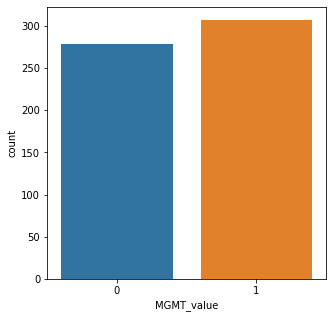

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.countplot(data=train_df, x="MGMT_value");

In [4]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def visualize_sample(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

In [5]:
submission = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")
# submission.to_csv("submission.csv", index=False)
submission

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [6]:
import pathlib
path ='../input/rsna-miccai-png/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=123,
  # image_size=(img_height, img_width),
  # batch_size=batch_size,
)


Found 253856 files belonging to 585 classes.
Using 203085 files for training.


In [7]:
class_names = train_ds.class_names
print(class_names)

['00000', '00002', '00003', '00005', '00006', '00008', '00009', '00011', '00012', '00014', '00017', '00018', '00019', '00020', '00021', '00022', '00024', '00025', '00026', '00028', '00030', '00031', '00032', '00033', '00035', '00036', '00043', '00044', '00045', '00046', '00048', '00049', '00052', '00053', '00054', '00056', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00066', '00068', '00070', '00071', '00072', '00074', '00077', '00078', '00081', '00084', '00085', '00087', '00088', '00089', '00090', '00094', '00095', '00096', '00097', '00098', '00099', '00100', '00102', '00104', '00105', '00106', '00107', '00108', '00109', '00110', '00111', '00112', '00113', '00116', '00117', '00120', '00121', '00122', '00123', '00124', '00128', '00130', '00132', '00133', '00134', '00136', '00137', '00138', '00139', '00140', '00142', '00143', '00144', '00146', '00147', '00148', '00149', '00150', '00151', '00154', '00155', '00156', '00157', '00158', '00159', '00160', '00162', '00165', 

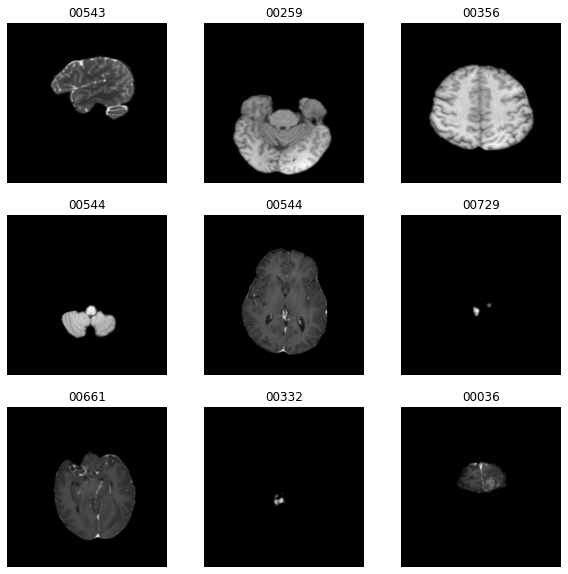

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
path2 ='../input/rsna-miccai-png/train/00000'
img_type = tf.keras.preprocessing.image_dataset_from_directory(
  path2,
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=123,
  # image_size=(img_height, img_width),
  # batch_size=batch_size,
)

Found 677 files belonging to 4 classes.
Using 542 files for training.


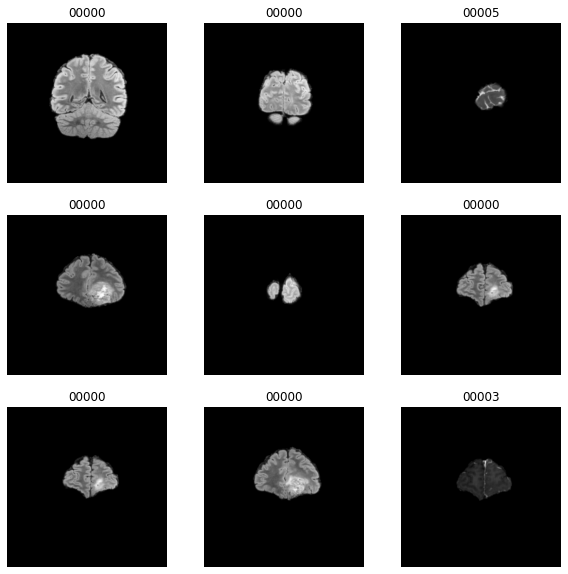

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in img_type.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
root_dir = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"
types = ["FLAIR","T1w","T1wCE","T2w"]
_new = []

for index, num in enumerate(train_df["BraTS21ID"]):
    a = []
    for i in range(len(types)):
        _path = root_dir + str(num).zfill(5)
        tpath = os.path.join(_path, types[i])
        lists = os.listdir(tpath)
        a.append(len(lists))
    
    _new.append([train_df["BraTS21ID"].iloc[index],train_df["MGMT_value"].iloc[index],a[0], a[1], a[2], a[3]])

new_df = pd.DataFrame(_new)
new_df.columns = ["BraTS21Id", "MGMT_value","FLAIR", "T1w", "T1wCE", "T2w"]

new_df

,BraTS21Id,MGMT_value,FLAIR,T1w,T1wCE,T2w
0,0,1,400,33,129,408
1,2,1,129,31,129,384
2,3,0,129,33,129,408
3,5,1,400,28,129,424
4,6,1,129,32,129,408
...,...,...,...,...,...,...
580,1005,1,23,23,23,23
581,1007,1,124,124,124,124
582,1008,1,60,192,192,64
583,1009,0,23,23,23,23


## ✋ I found that sizes are different per patients ✋

In [12]:
img_1_png = Image.open("../input/rsna-miccai-png/train/00000/FLAIR/Image-100.png")
img_1_png.size

(512, 512)

In [13]:
img_2_png = Image.open("../input/rsna-miccai-png/train/00137/T1wCE/Image-29.png")
img_2_png.size

(256, 256)

## 00000 shape is (512,512)

In [14]:
path = "../input/rsna-miccai-png/train/00000"
sizes = []
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    names = os.listdir(folder_path)
    
    for name in names:
        png_path = os.path.join(folder_path, name)
        
        im_size = Image.open(png_path).size
        sizes.append(im_size)
print(names)

print(set(sizes))

['Image-79.png', 'Image-223.png', 'Image-232.png', 'Image-257.png', 'Image-64.png', 'Image-230.png', 'Image-130.png', 'Image-129.png', 'Image-177.png', 'Image-322.png', 'Image-140.png', 'Image-144.png', 'Image-281.png', 'Image-234.png', 'Image-266.png', 'Image-241.png', 'Image-194.png', 'Image-156.png', 'Image-48.png', 'Image-262.png', 'Image-242.png', 'Image-109.png', 'Image-333.png', 'Image-292.png', 'Image-210.png', 'Image-174.png', 'Image-184.png', 'Image-110.png', 'Image-89.png', 'Image-108.png', 'Image-331.png', 'Image-195.png', 'Image-272.png', 'Image-273.png', 'Image-283.png', 'Image-105.png', 'Image-213.png', 'Image-46.png', 'Image-49.png', 'Image-126.png', 'Image-277.png', 'Image-225.png', 'Image-81.png', 'Image-218.png', 'Image-313.png', 'Image-205.png', 'Image-165.png', 'Image-102.png', 'Image-163.png', 'Image-318.png', 'Image-172.png', 'Image-123.png', 'Image-309.png', 'Image-189.png', 'Image-100.png', 'Image-233.png', 'Image-211.png', 'Image-152.png', 'Image-88.png', 'Ima

## 00137 shape is (256,256)

In [15]:
path = "../input/rsna-miccai-png/train/00137"
sizes = []
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    names = os.listdir(folder_path)
    
    for name in names:
        png_path = os.path.join(folder_path, name)
        
        im_size = Image.open(png_path).size
        sizes.append(im_size)
print(names)

print(set(sizes))

['Image-41.png', 'Image-25.png', 'Image-20.png', 'Image-4.png', 'Image-38.png', 'Image-26.png', 'Image-32.png', 'Image-19.png', 'Image-28.png', 'Image-5.png', 'Image-33.png', 'Image-23.png', 'Image-9.png', 'Image-22.png', 'Image-8.png', 'Image-7.png', 'Image-17.png', 'Image-34.png', 'Image-40.png', 'Image-6.png', 'Image-13.png', 'Image-36.png', 'Image-37.png', 'Image-10.png', 'Image-30.png', 'Image-24.png', 'Image-39.png', 'Image-15.png', 'Image-18.png', 'Image-11.png', 'Image-31.png', 'Image-21.png', 'Image-12.png', 'Image-27.png', 'Image-1.png', 'Image-2.png', 'Image-3.png', 'Image-16.png', 'Image-29.png', 'Image-35.png', 'Image-14.png']
{(256, 256)}


In [16]:
root_dir = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"
types = ["FLAIR","T1w","T1wCE","T2w"]
_new = []

for index, num in enumerate(train_df["BraTS21ID"]):
    a = []
    for i in range(len(types)):
        _path = root_dir + str(num).zfill(5)
        tpath = os.path.join(_path, types[i])
        lists = os.listdir(tpath)
        a.append(len(lists))
    
    _new.append([train_df["BraTS21ID"].iloc[index],train_df["MGMT_value"].iloc[index],a[0], a[1], a[2], a[3]])

new_df = pd.DataFrame(_new)
new_df.columns = ["BraTS21Id", "MGMT_value","FLAIR", "T1w", "T1wCE", "T2w"]

new_df


,BraTS21Id,MGMT_value,FLAIR,T1w,T1wCE,T2w
0,0,1,400,33,129,408
1,2,1,129,31,129,384
2,3,0,129,33,129,408
3,5,1,400,28,129,424
4,6,1,129,32,129,408
...,...,...,...,...,...,...
580,1005,1,23,23,23,23
581,1007,1,124,124,124,124
582,1008,1,60,192,192,64
583,1009,0,23,23,23,23


## Check files shape per patients ✔

In [17]:
 if __name__ == "__main__":
    root_dir = "../input/rsna-miccai-png/train"
    sizes = []
    csv_path = "imagetype.csv"
    with open(csv_path, 'w') as f: 
        f.write('path,height,width,size\n') 
    for (root, dirs, files) in os.walk(root_dir):
        print("# root : " + root)
        
        if len(files) > 0:
            for file_name in files:
                png_path = os.path.join(root, file_name)
                # print("file: " + file_name)
                
                im_size = Image.open(png_path).size
                with open(csv_path, 'a+') as f:  
                    f.write(f'{png_path},{im_size[0]},{im_size[1]},({im_size[0]}x{im_size[1]})\n')



# root : ../input/rsna-miccai-png/train
# root : ../input/rsna-miccai-png/train/00688
# root : ../input/rsna-miccai-png/train/00688/T2w
# root : ../input/rsna-miccai-png/train/00688/T1wCE
# root : ../input/rsna-miccai-png/train/00688/T1w
# root : ../input/rsna-miccai-png/train/00688/FLAIR
# root : ../input/rsna-miccai-png/train/00058
# root : ../input/rsna-miccai-png/train/00058/T2w
# root : ../input/rsna-miccai-png/train/00058/T1wCE
# root : ../input/rsna-miccai-png/train/00058/T1w
# root : ../input/rsna-miccai-png/train/00058/FLAIR
# root : ../input/rsna-miccai-png/train/00516
# root : ../input/rsna-miccai-png/train/00516/T2w
# root : ../input/rsna-miccai-png/train/00516/T1wCE
# root : ../input/rsna-miccai-png/train/00516/T1w
# root : ../input/rsna-miccai-png/train/00516/FLAIR
# root : ../input/rsna-miccai-png/train/00185
# root : ../input/rsna-miccai-png/train/00185/T2w
# root : ../input/rsna-miccai-png/train/00185/T1wCE
# root : ../input/rsna-miccai-png/train/00185/T1w
# root : ../

## ⚠ Due to quantities of files, I spent time too much to load 📊
## images are over 250k, so I decided to make a csv file 💾 

In [18]:
imagetype_csv = pd.read_csv('./imagetype.csv')
imagetype_csv.shape

(253856, 4)

## Change CSV file into DataFrame 

In [19]:
image_df = pd.read_csv('./imagetype.csv',index_col = False)
image_df

,path,height,width,size
0,../input/rsna-miccai-png/train/00688/T2w/Image...,512,512,(512x512)
1,../input/rsna-miccai-png/train/00688/T2w/Image...,512,512,(512x512)
2,../input/rsna-miccai-png/train/00688/T2w/Image...,512,512,(512x512)
3,../input/rsna-miccai-png/train/00688/T2w/Image...,512,512,(512x512)
4,../input/rsna-miccai-png/train/00688/T2w/Image...,512,512,(512x512)
...,...,...,...,...
253851,../input/rsna-miccai-png/train/00049/FLAIR/Ima...,512,512,(512x512)
253852,../input/rsna-miccai-png/train/00049/FLAIR/Ima...,512,512,(512x512)
253853,../input/rsna-miccai-png/train/00049/FLAIR/Ima...,512,512,(512x512)
253854,../input/rsna-miccai-png/train/00049/FLAIR/Ima...,512,512,(512x512)


## Check height and width image sizes

In [20]:
image_df['height'].value_counts()

512     126959
192      52497
256      51084
208       8176
384       5561
448       1979
320       1325
232       1168
416        857
224        627
260        550
440        491
480        457
640        336
244        287
240        216
280        199
336        122
432        113
406        107
272         74
672         69
312         60
290         59
250         56
348         53
288         52
364         51
204         48
464         48
768         46
408         36
236         30
424         23
1014        20
216         20
Name: height, dtype: int64

In [21]:
image_df['width'].value_counts() 

512     134615
256     113531
320       2457
448       1191
440        491
640        435
480        314
244        287
384        278
240         72
672         69
232         50
768         46
1024        20
Name: width, dtype: int64

In [22]:
image_df['size'].value_counts()

(512x512)      126829
(192x256)       52497
(256x256)       50995
(208x256)        8176
(384x512)        5561
(320x320)        1306
(232x256)        1168
(448x512)        1104
(448x448)         875
(416x512)         857
(224x256)         627
(260x320)         550
(440x440)         491
(640x640)         336
(480x480)         314
(244x244)         287
(280x320)         199
(240x320)         144
(512x448)         130
(432x512)         113
(406x448)         107
(480x640)          99
(336x384)          94
(272x320)          74
(240x240)          72
(672x672)          69
(312x384)          60
(290x320)          59
(250x320)          56
(348x384)          53
(288x384)          52
(364x448)          51
(256x232)          50
(464x512)          48
(204x256)          48
(768x768)          46
(480x512)          44
(256x320)          39
(408x512)          36
(236x320)          30
(336x448)          28
(424x512)          23
(216x256)          20
(1014x1024)        20
(320x384)          19
Name: size

### 50% is (512,512) 20% is (192,256), and about 20% is (256,256)

In [23]:
 if __name__ == "__main__":
    root_dir = "../input/rsna-miccai-png/test"
    sizes = []
    csv_path = "imagetype_test.csv"
    with open(csv_path, 'w') as f: 
        f.write('path,height,width,size\n') 
    for (root, dirs, files) in os.walk(root_dir):
        print("# root : " + root)
        
        if len(files) > 0:
            for file_name in files:
                png_path = os.path.join(root, file_name)
                # print("file: " + file_name)
                
                im_size = Image.open(png_path).size
                with open(csv_path, 'a+') as f:  
                    f.write(f'{png_path},{im_size[0]},{im_size[1]},({im_size[0]}x{im_size[1]})\n')



# root : ../input/rsna-miccai-png/test
# root : ../input/rsna-miccai-png/test/00114
# root : ../input/rsna-miccai-png/test/00114/T2w
# root : ../input/rsna-miccai-png/test/00114/T1wCE
# root : ../input/rsna-miccai-png/test/00114/T1w
# root : ../input/rsna-miccai-png/test/00114/FLAIR
# root : ../input/rsna-miccai-png/test/00013
# root : ../input/rsna-miccai-png/test/00013/T2w
# root : ../input/rsna-miccai-png/test/00013/T1wCE
# root : ../input/rsna-miccai-png/test/00013/T1w
# root : ../input/rsna-miccai-png/test/00013/FLAIR
# root : ../input/rsna-miccai-png/test/00821
# root : ../input/rsna-miccai-png/test/00821/T2w
# root : ../input/rsna-miccai-png/test/00821/T1wCE
# root : ../input/rsna-miccai-png/test/00821/T1w
# root : ../input/rsna-miccai-png/test/00821/FLAIR
# root : ../input/rsna-miccai-png/test/00644
# root : ../input/rsna-miccai-png/test/00644/T2w
# root : ../input/rsna-miccai-png/test/00644/T1wCE
# root : ../input/rsna-miccai-png/test/00644/T1w
# root : ../input/rsna-miccai-pn

In [24]:
image_test_df = pd.read_csv('./imagetype_test.csv',index_col = False)
image_test_df

,path,height,width,size
0,../input/rsna-miccai-png/test/00114/T2w/Image-...,224,256,(224x256)
1,../input/rsna-miccai-png/test/00114/T2w/Image-...,224,256,(224x256)
2,../input/rsna-miccai-png/test/00114/T2w/Image-...,224,256,(224x256)
3,../input/rsna-miccai-png/test/00114/T2w/Image-...,224,256,(224x256)
4,../input/rsna-miccai-png/test/00114/T2w/Image-...,224,256,(224x256)
...,...,...,...,...
37062,../input/rsna-miccai-png/test/00182/FLAIR/Imag...,208,256,(208x256)
37063,../input/rsna-miccai-png/test/00182/FLAIR/Imag...,208,256,(208x256)
37064,../input/rsna-miccai-png/test/00182/FLAIR/Imag...,208,256,(208x256)
37065,../input/rsna-miccai-png/test/00182/FLAIR/Imag...,208,256,(208x256)


In [25]:
image_test_df['size'].value_counts()

(512x512)    18847
(192x256)     7479
(256x256)     6781
(384x512)     1371
(208x256)     1179
(224x256)      266
(260x320)      211
(448x512)      159
(320x320)      154
(448x448)      147
(440x440)      144
(416x512)       82
(244x244)       72
(640x640)       49
(312x384)       32
(364x448)       24
(400x512)       24
(424x512)       23
(240x320)       23
Name: size, dtype: int64